<a href="https://colab.research.google.com/github/kerenslendyrc/Estadistica/blob/main/Edpractica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files # para cargar archivos en google colab
upload = files.upload()

Saving Base de datos.xlsx to Base de datos.xlsx


In [2]:
import pandas as pd
print(pd.__version__)
print(pd.__file__)

2.2.2
/usr/local/lib/python3.12/dist-packages/pandas/__init__.py


In [3]:
!pip install factor-analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=b2959a0b43b5247208dd51da4c84f0b2fc6fb5991eb42ec308844fa64ee20123
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor-analyzer


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity



In [5]:
import pandas as pd
import numpy as np
df = pd.read_excel("Base de datos.xlsx")

df_work = df.copy()

In [6]:
df["fallecimiento_SN"] = df["fecha_muerte"].notna().map({True: "SI", False: "NO"})

In [7]:
def capitulo_cie10(code):
    if pd.isna(code):
        return pd.NA
    c = str(code).strip()
    if len(c) == 0:
        return pd.NA
    return c[0]   # A, B, C, D, ...

df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)


In [8]:
map_capitulos = {
    "A": "Infecciosas_parasitarias",
    "B": "Infecciosas_parasitarias",
    "C": "Neoplasias",
    "D": "Neoplasias_sangre",
    "E": "Endocrinas_nutricionales",
    "F": "Trastornos_mentales",
    "G": "Sistema_nervioso",
    "H": "Ojo_oido",
    "I": "Cardiovasculares",
    "J": "Respiratorias",
    "K": "Digestivas",
    "L": "Piel_tejido_subcutaneo",
    "M": "Musculoesqueleticas",
    "N": "Genitourinarias",
    "O": "Embarazo_parto_puerperio",
    "P": "Perinatales",
    "Q": "Malformaciones_congenitas",
    "R": "Sintomas_signos_mal_definidos",
    "S": "Traumatismos",
    "T": "Envenenamientos_y_otros_consec",
    "V": "Causas_externas_transporte",
    "W": "Causas_externas_otros",
    "X": "Causas_externas_otros2",
    "Y": "Causas_externas_otros3",
    "Z": "Factores_contacto_servicios",
}

# Rehacer la columna agrupada:
df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)
df["grupo_causa_muerte"] = df["capitulo_causa_muerte"].map(map_capitulos)

# Si alguna letra no estaba en el diccionario, la mandas a "OTRO"
df["grupo_causa_muerte"] = df["grupo_causa_muerte"].fillna("OTRO")

# Ver ahora las categorías
df["grupo_causa_muerte"].value_counts()


,count
grupo_causa_muerte,
OTRO,138271
Neoplasias,682
Sintomas_signos_mal_definidos,615
Respiratorias,503
Cardiovasculares,346
Infecciosas_parasitarias,143
Digestivas,119
Neoplasias_sangre,90
Genitourinarias,74


In [9]:
# 1) Crear fallecimiento_SN si no lo tienes aún
df["fallecimiento_SN"] = df["fecha_muerte"].notna().map({True: "SI", False: "NO"})

# 2) Crear capítulo y grupo solo para quienes tienen código
df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)

df["grupo_causa_muerte"] = df["capitulo_causa_muerte"].map(map_capitulos)

# 3) Diferenciar bien:
# - NO_APLICA si no falleció
# - OTRO solo si falleció pero la letra no está en el map_capitulos
df.loc[df["fallecimiento_SN"] == "NO", "grupo_causa_muerte"] = "NO_APLICA"
df.loc[
    (df["fallecimiento_SN"] == "SI") & (df["grupo_causa_muerte"].isna()),
    "grupo_causa_muerte"
] = "OTRO"

df["grupo_causa_muerte"].value_counts()


,count
grupo_causa_muerte,
NO_APLICA,138098
Neoplasias,681
Sintomas_signos_mal_definidos,615
Respiratorias,502
Cardiovasculares,346
OTRO,175
Infecciosas_parasitarias,143
Digestivas,119
Neoplasias_sangre,90


In [10]:
def agrupar_uo_medico_macro(uo):
    if pd.isna(uo):
        return "OTRA"
    u = str(uo).upper()

    # Cuidados intensivos
    if "INTEN" in u:  # 1MHINTEN
        return "UCI"

    # Pediatría
    if "PEDIA" in u or "CXPED" in u or "ORTPE" in u or "NEONA" in u or "ORPED" in u or "OFPED" in u:
        return "PEDIATRIA"

    # Ginecología / Obstetricia
    if "GINEC" in u or "GINEO" in u or "CACUE" in u:  # CACUE lo mando a gineco-onco
        return "GINECOLOGIA"

    # Medicina Interna
    if "MEINT" in u:
        return "MEDICINA_INTERNA"

    # Cirugía (general y subespecialidades CX***, COLOP, etc.)
    if "CX" in u or "COLOP" in u:
        return "CIRUGIA"

    # Urología
    if "UROLO" in u or "UROLP" in u or "URONC" in u:
        return "UROLOGIA"

    # Hematología / Hemato-oncología
    if "HEMAT" in u or "HEMTR" in u or "HEONP" in u or "HE-ON" in u or "HEMAP" in u:
        return "HEMATOLOGIA_ONCO"

    # Oncología (códigos ONCO específicos)
    if "ONCOL" in u or "ONCOP" in u or "CXONC" in u or "ORON" in u:
        return "ONCOLOGIA"

    # Oftalmología
    if "OFTAL" in u or "OFPLA" in u or "RETIN" in u or "OFPED" in u or "NEUOF" in u:
        return "OFTALMOLOGIA"

    # Neurología
    if "NEURO" in u or "NEURP" in u:
        return "NEUROLOGIA"

    # Nefrología
    if "NEFRO" in u or "NEFTR" in u or "NEFRP" in u:
        return "NEFROLOGIA"

    # Ortopedia
    if "ORTOP" in u or "ORTOD" in u:
        return "ORTOPEDIA"

    # Alergia
    if "ALERG" in u:
        return "ALERGOLOGIA"

    # Geriatría
    if "GERIA" in u:
        return "GERIATRIA"

    # Cardiología
    if "CARDI" in u:
        return "CARDIOLOGIA"

    # Gastroenterología
    if "GASTR" in u or "GASTP" in u:
        return "GASTROENTEROLOGIA"

    # Otorrino
    if "OTORR" in u or "OTOLO" in u:
        return "OTORRINOLARINGOLOGIA"

    # Imagen/diagnóstico (radiología, med nuclear, laboratorio especial)
    if "RADIN" in u or "RADIO" in u or "MENUC" in u or "MELAB" in u:
        return "IMAGENOLOGIA"

    # Reumatología
    if "REUMA" in u or "REUMP" in u:
        return "REUMATOLOGIA"

    # Endocrinología
    if "ENDOC" in u:
        return "ENDOCRINOLOGIA"

    # Urgencias
    if "URGEN" in u:
        return "URGENCIAS"

    # Anestesiología
    if "ANECL" in u:
        return "ANESTESIOLOGIA"

    return "OTRA"

# Recalcular la macro-categoría
df["uo_medico_macro"] = df["uo_medico"].apply(agrupar_uo_medico_macro)

# Ver cómo queda ahora la distribución
df["uo_medico_macro"].value_counts()


,count
uo_medico_macro,
MEDICINA_INTERNA,54633
GINECOLOGIA,30799
PEDIATRIA,17409
CIRUGIA,15668
HEMATOLOGIA_ONCO,6746
UROLOGIA,4853
ORTOPEDIA,3865
ANESTESIOLOGIA,2861
URGENCIAS,1205


In [11]:
df.loc[df["uo_medico_macro"] == "OTRA", "uo_medico"].value_counts().head(20)


,count
uo_medico,
1MHPERIN,6
1MHINFEC,5
1MHANDRO,4
1MHCARDP,3
1MHCARIN,3
1MHINTEP,2
1MHOFCOR,2
1MHOFSEG,2
1MHNEUMO,1


In [12]:
# Ver las unidades más frecuentes
vc_uo = df["id_discapacidad"].value_counts()
top_uo = vc_uo.head(50).index   # por ejemplo, las 20 más frecuentes

# Crear grupo: top unidades vs resto
df["id_discapacidad_top"] = df["id_discapacidad"].where(df["id_discapacidad"].isin(top_uo), "OTRAS_UNIDADES")

df["id_discapacidad_top"].value_counts()


,count
id_discapacidad_top,
Ninguna,103486
OTRAS_UNIDADES,27745
Movimiento cuerpo extremidades,3277
El sistema nervioso,1457
Cardiorespiratorio y/o defensas,1278
"El sistema nervioso, Movimiento cuerpo extremidades",831
Los ojos,668
Los oÃ­dos,308
RENAL,298


In [13]:
def agrupar_discapacidad_macro(desc):
    # 1) Faltantes o punto suelto
    if pd.isna(desc):
        return "DESCONOCIDA"
    s = str(desc).upper().strip()

    # 2) Sin discapacidad
    if "NINGUNA" in s or s == "NINGUNA" or "NO APLICA" in s:
        return "SIN_DISCAPACIDAD"

    # 3) Preparamos flags por sistema / tipo
    grupos = []

    # Motora / aparato locomotor
    if "MOVIMIENTO CUERPO" in s or "EXTREMIDADES" in s:
        grupos.append("MOTORA")
    if "ÓSEA" in s or "Ã“SEA" in s or "OSEA" in s:
        grupos.append("MOTORA")

    # Neurológica / cognitiva
    if "SISTEMA NERVIOSO" in s or "DEMENCIA" in s:
        grupos.append("NEUROLOGICA")

    # Cardiorrespiratorio y defensas
    if "CARDIORRESPIRATORIO" in s or "CARDIORESPIRATORIO" in s or "DEFENSAS" in s:
        grupos.append("CARDIORESPIRATORIA_DEFENSAS")

    # Sensorial visual
    if "LOS OJOS" in s or "OJOS" in s:
        grupos.append("SENSORIAL_VISUAL")

    # Sensorial auditiva (ojo con caracteres raros)
    if "LOS OÍDOS" in s or "LOS OIDOS" in s or "LOS OÃDOS" in s or "OÍDOS" in s or "OIDOS" in s or "OÃDOS" in s:
        grupos.append("SENSORIAL_AUDITIVA")

    # Comunicación (voz y habla)
    if "VOZ" in s or "HABLA" in s:
        grupos.append("COMUNICACION")

    # Renal
    if "RENAL" in s:
        grupos.append("RENAL")

    # Metabólica / endocrina / digestiva
    if "DIGESTI" in s or "METABOL" in s or "HORMONAL" in s or "OBESIDAD" in s or "ENDOCR" in s:
        grupos.append("METABOLICA_ENDOCRINA")

    # Piel
    if "LA PIEL" in s or "PIEL" in s:
        grupos.append("PIEL")

    # Genital / reproductivo
    if "GENITAL" in s or "REPRODUCTIVO" in s:
        grupos.append("GENITAL_REPRODUCTIVO")

    # Inmunidad / hematológica / onco-hemato
    if "INMUNIDAD" in s or "HEMATOLOGICA" in s or "CITOPENIAS" in s or "HODGKIN" in s:
        grupos.append("INMUNO_HEMATOLOGICA")

    # 4) Si tiene varias áreas a la vez → MULTIPLE
    grupos_unicos = list(set(grupos))

    if len(grupos_unicos) == 0:
        # Casos especiales que son más bien diagnósticos pero los tiramos a INMUNO/HEMATO o OTRA
        if "CA DE MAMA" in s or "MAMA" in s:
            return "INMUNO_HEMATOLOGICA"
        if "QUIMIOTERAPIA" in s:
            return "INMUNO_HEMATOLOGICA"
        if "EDAD" in s:
            return "MOTORA"   # fragilidad asociada a edad, si quieres puedes crear una categoría aparte
        if "OTRAS_UNIDADES" in s or s == ".":
            return "OTRA"
        # Nada matchea → OTRA
        return "OTRA"

    if len(grupos_unicos) == 1:
        return grupos_unicos[0]

    # Si tiene más de un sistema comprometido
    return "MULTIPLE"


# Aplicar sobre la columna de texto de discapacidad
df["tipo_discapacidad_macro"] = df["id_discapacidad_top"].apply(agrupar_discapacidad_macro)

# Ver cómo quedó
df["tipo_discapacidad_macro"].value_counts()


,count
tipo_discapacidad_macro,
SIN_DISCAPACIDAD,103591
OTRA,28118
MOTORA,3443
MULTIPLE,1585
NEUROLOGICA,1476
CARDIORESPIRATORIA_DEFENSAS,1278
SENSORIAL_VISUAL,704
RENAL,332
METABOLICA_ENDOCRINA,232


In [14]:
df.loc[df["tipo_discapacidad_macro"] == "OTRA", "id_discapacidad_top"] \
  .value_counts() \
  .head(30)


,count
id_discapacidad_top,
OTRAS_UNIDADES,27745
Los oÃ­dos,308
.,41
Olfato tacto y/o gusto,24


In [15]:
# 1) Los oídos → sensorial auditiva
mask_oidos = df["id_discapacidad_top"].str.contains("Los oÃ­dos", case=False, na=False)
df.loc[mask_oidos, "tipo_discapacidad_macro"] = "SENSORIAL_AUDITIVA"

# 2) Olfato tacto y/o gusto → sensorial otros
mask_olfato = df["id_discapacidad_top"].str.contains("Olfato tacto y/o gusto", case=False, na=False)
df.loc[mask_olfato, "tipo_discapacidad_macro"] = "SENSORIAL_OTROS"

# 3) Si quieres separar el punto como DESCONOCIDA
mask_punto = df["id_discapacidad_top"].eq(".")
df.loc[mask_punto, "tipo_discapacidad_macro"] = "DESCONOCIDA"

# Ver cómo queda
df["tipo_discapacidad_macro"].value_counts()


,count
tipo_discapacidad_macro,
SIN_DISCAPACIDAD,103533
OTRA,27745
MOTORA,3348
MULTIPLE,1585
NEUROLOGICA,1476
CARDIORESPIRATORIA_DEFENSAS,1278
SENSORIAL_VISUAL,668
SENSORIAL_AUDITIVA,522
RENAL,332


In [16]:
import numpy as np
import pandas as pd

# 1) Estandarizar nombres de ciudad y departamento
df['ciudad_clean'] = (
    df['ciudad']
    .astype(str)
    .str.strip()
    .str.upper()
)

df['departamento_clean'] = (
    df['departamento']
    .astype(str)
    .str.strip()
    .str.upper()
)

# 2) Diccionario municipio -> provincia (solo SANTANDER)
provincia_map = {
    # --- METROPOLITANA ---
    'BUCARAMANGA': 'Metropolitana',
    'FLORIDABLANCA': 'Metropolitana',
    'GIRÓN': 'Metropolitana',
    'GIRON': 'Metropolitana',        # por si viene sin tilde
    'PIEDECUESTA': 'Metropolitana',
    'LEBRIJA': 'Metropolitana',
    'LOS SANTOS': 'Metropolitana',
    'RIONEGRO': 'Metropolitana',
    'SANTA BÁRBARA': 'Metropolitana',
    'SANTA BARBARA': 'Metropolitana',
    'ZAPATOCA': 'Metropolitana',
    'EL PLAYÓN': 'Metropolitana',
    'EL PLAYON': 'Metropolitana',
    # Decide tú si TONA va aquí o en Soto Norte:
    'TONA': 'Metropolitana',

    # --- COMUNERA ---
    'CHIMA': 'Comunera',
    'CONFINES': 'Comunera',
    'CONTRATACIÓN': 'Comunera',
    'CONTRATACION': 'Comunera',
    'EL GUACAMAYO': 'Comunera',
    'GALÁN': 'Comunera',
    'GALAN': 'Comunera',
    'GÁMBITA': 'Comunera',
    'GAMBITA': 'Comunera',
    'GUADALUPE': 'Comunera',
    'GUAPOTÁ': 'Comunera',
    'GUAPOTA': 'Comunera',
    'HATO': 'Comunera',
    'OIBA': 'Comunera',
    'PALMAR': 'Comunera',
    'PALMAS DEL SOCORRO': 'Comunera',
    'SANTA HELENA DEL OPÓN': 'Comunera',
    'SANTA HELENA DEL OPON': 'Comunera',
    'SIMACOTA': 'Comunera',
    'SOCORRO': 'Comunera',
    'SUAITA': 'Comunera',

    # --- VÉLEZ ---
    'AGUADA': 'Vélez',
    'ALBANIA': 'Vélez',
    'BARBOSA': 'Vélez',
    'BOLÍVAR': 'Vélez',
    'BOLIVAR': 'Vélez',
    'CHIPATÁ': 'Vélez',
    'CHIPATA': 'Vélez',
    'CIMITARRA': 'Vélez',
    'EL PEÑÓN': 'Vélez',
    'EL PENON': 'Vélez',
    'FLORIÁN': 'Vélez',
    'FLORIAN': 'Vélez',
    'GUAVATÁ': 'Vélez',
    'GUAVATA': 'Vélez',
    'GÜEPSA': 'Vélez',
    'GUEPSA': 'Vélez',
    'JESÚS MARÍA': 'Vélez',
    'JESUS MARIA': 'Vélez',
    'LA BELLEZA': 'Vélez',
    'LA PAZ': 'Vélez',
    'LANDÁZURI': 'Vélez',
    'LANDAZURI': 'Vélez',
    'PUENTE NACIONAL': 'Vélez',
    'PUERTO PARRA': 'Vélez',
    'SAN BENITO': 'Vélez',
    'SUAREZ': 'Vélez',   # si apareciera así en tus datos
    'SUCRE': 'Vélez',
    'VÉLEZ': 'Vélez',
    'VELEZ': 'Vélez',

    # --- GUANENTÁ ---
    'ARATOCA': 'Guanentá',
    'BARICHARA': 'Guanentá',
    'CABRERA': 'Guanentá',
    'CHARALÁ': 'Guanentá',
    'CHARALA': 'Guanentá',
    'COROMORO': 'Guanentá',
    'CURITÍ': 'Guanentá',
    'CURITI': 'Guanentá',
    'ENCINO': 'Guanentá',
    'JORDÁN': 'Guanentá',
    'JORDAN': 'Guanentá',
    'MOGOTES': 'Guanentá',
    'OCAMONTE': 'Guanentá',
    'ONZAGA': 'Guanentá',
    'PÁRAMO': 'Guanentá',
    'PARAMO': 'Guanentá',
    'PINCHOTE': 'Guanentá',
    'SAN GIL': 'Guanentá',
    'SAN JOAQUÍN': 'Guanentá',
    'SAN JOAQUIN': 'Guanentá',
    'VALLE DE SAN JOSÉ': 'Guanentá',
    'VALLE DE SAN JOSE': 'Guanentá',
    'VILLANUEVA': 'Guanentá',

    # --- GARCÍA ROVIRA ---
    'CAPITANEJO': 'García Rovira',
    'CARCASÍ': 'García Rovira',
    'CARCASI': 'García Rovira',
    'CEPITÁ': 'García Rovira',
    'CEPITA': 'García Rovira',
    'CERRITO': 'García Rovira',
    'CONCEPCIÓN': 'García Rovira',
    'CONCEPCION': 'García Rovira',
    'ENCISO': 'García Rovira',
    'GUACA': 'García Rovira',
    'MACARAVITA': 'García Rovira',
    'MÁLAGA': 'García Rovira',
    'MALAGA': 'García Rovira',
    'MOLAGAVITA': 'García Rovira',
    'SAN ANDRÉS': 'García Rovira',
    'SAN ANDRES': 'García Rovira',
    'SAN JOSÉ DE MIRANDA': 'García Rovira',
    'SAN JOSE DE MIRANDA': 'García Rovira',
    'SAN MIGUEL': 'García Rovira',

    # --- YARIGUÍES ---
    'BARRANCABERMEJA': 'Yariguíes',
    'BETULIA': 'Yariguíes',
    'EL CARMEN DE CHUCURÍ': 'Yariguíes',
    'EL CARMEN DE CHUCURI': 'Yariguíes',
    'PUERTO WILCHES': 'Yariguíes',
    'SABANA DE TORRES': 'Yariguíes',
    'SAN VICENTE DE CHUCURÍ': 'Yariguíes',
    'SAN VICENTE DE CHUCURI': 'Yariguíes',

    # --- SOTO / SOTO NORTE ---
    'CALIFORNIA': 'Soto Norte',
    'CHARTA': 'Soto Norte',
    'MATANZA': 'Soto Norte',
    'SURATÁ': 'Soto Norte',
    'SURATA': 'Soto Norte',
    'VETAS': 'Soto Norte',
    # Si prefieres que Tona quede aquí:
    # 'TONA': 'Soto Norte',
}

# 3) Crear la variable provincia_ciudad para SANTANDER
df['provincia_ciudad'] = df['ciudad_clean'].map(provincia_map)

# 4) Asignar 'Otros departamentos' para todo lo que no es Santander
df.loc[df['departamento_clean'] != 'SANTANDER', 'provincia_ciudad'] = 'Otros departamentos'

# 5) Cualquier municipio de Santander no mapeado explícitamente también va a 'Otros departamentos'
df['provincia_ciudad'] = df['provincia_ciudad'].fillna('Otros departamentos')

# Opcional: revisar distribución
print(df['provincia_ciudad'].value_counts(dropna=False))


provincia_ciudad
Metropolitana          116917
Otros departamentos      9042
Yariguíes                6759
Guanentá                 3751
Vélez                    1832
Comunera                 1432
García Rovira             852
Soto Norte                570
Name: count, dtype: int64


In [17]:
eps_counts = df['EPS'].value_counts(dropna=False)
print(eps_counts.head(30))


EPS
NUEVA EPS                        103886
FIDUPREVISORA                     12194
ECOPETROL                          4694
EPS SANITAS                        3975
COLSANITAS                         1884
EPS FAMISANAR                      1728
SURAMERICANA SA                    1693
CLINICA SANTA CRUZ DE LA LOMA      1446
COOSALUD EPS                       1269
AXA COLPATRIA                      1216
SALUD TOTAL EPS                     795
ALLIANZ SEGUROS                     720
MEDISANITAS                         623
COLMEDICA MEDICINA PREPAGADA        537
COOMEVA EPS                         439
UIS                                 397
SEGUROS BOLIVAR                     360
PACIENTE PARTICULAR                 288
SALUD TOTAL SUBSIADO                250
HDI SEGUROS (ANTES LIBERTY)         224
MED PLUS MEDICINA PREPAGADA         212
COMPENSAR EPS                       198
CORSO SALAMANCA JAIRO               183
FUNDACION MEDICO PREVENTIVA         169
COMPAÃ‘IA MUNDIAL DE SEGUROS        

In [18]:
# 1) Limpieza básica
df['EPS_clean'] = (
    df['EPS']
    .astype(str)
    .str.strip()
    .str.upper()
)

# 2) Unificar TODAS las variantes que contengan "NUEVA EPS"
mask_nueva = df['EPS_clean'].str.contains('NUEVA EPS', na=False)
df.loc[mask_nueva, 'EPS_clean'] = 'NUEVA EPS'

# 3) Recalcular frecuencias sobre la columna ya unificada
eps_freq = df['EPS_clean'].value_counts(normalize=True)

umbral_grande = 0.05
umbral_mediana_inf = 0.01

def clasificar_eps(eps):
    if pd.isna(eps):
        return 'EPS_no_reportada'
    if eps == 'NUEVA EPS':
        return 'EPS_NUEVA'
    f = eps_freq.get(eps, 0)
    if f >= umbral_grande:
        return 'EPS_grandes'
    elif f >= umbral_mediana_inf:
        return 'EPS_medianas'
    else:
        return 'EPS_pequeñas'

df['EPS_grupo'] = df['EPS_clean'].apply(clasificar_eps)

print(df.loc[df['EPS_clean'] == 'NUEVA EPS', 'EPS_grupo'].value_counts())


EPS_grupo
EPS_NUEVA    103887
Name: count, dtype: int64


In [19]:
# Ver todas las variantes que contienen "NUEVA EPS"
mask_nueva = df['EPS_clean'].str.contains('NUEVA EPS', na=False)

print(df.loc[mask_nueva, 'EPS_clean'].value_counts())
print(df.loc[mask_nueva, 'EPS_grupo'].value_counts())


EPS_clean
NUEVA EPS    103887
Name: count, dtype: int64
EPS_grupo
EPS_NUEVA    103887
Name: count, dtype: int64


In [20]:
import pandas as pd

# Tabla con EPS limpia, grupo y frecuencia absoluta
tabla_eps = (
    df
    .groupby(['EPS_grupo', 'EPS_clean'])
    .size()
    .reset_index(name='n_pacientes')
    .sort_values(['EPS_grupo', 'n_pacientes'], ascending=[True, False])
)

print("=== EPS por grupo (con número de pacientes) ===")
print(tabla_eps)

# Si quieres ver solo los nombres de EPS por grupo:
eps_por_grupo = (
    tabla_eps
    .groupby('EPS_grupo')['EPS_clean']
    .apply(list)
)

print("\n=== Listado de EPS en cada grupo ===")
for grupo, lista_eps in eps_por_grupo.items():
    print(f"\nGrupo: {grupo}")
    for eps in lista_eps:
        print(f"  - {eps}")


=== EPS por grupo (con número de pacientes) ===
       EPS_grupo                   EPS_clean  n_pacientes
0      EPS_NUEVA                   NUEVA EPS       103887
1    EPS_grandes               FIDUPREVISORA        12194
4   EPS_medianas                   ECOPETROL         4694
6   EPS_medianas                 EPS SANITAS         3975
3   EPS_medianas                  COLSANITAS         1884
..           ...                         ...          ...
53  EPS_pequeñas  LA Â CLINIC Â DU CORPS LTD            1
78  EPS_pequeñas   TRAVEL GUARD AMERICAS LLC            1
80  EPS_pequeñas                      UNACSA            1
83  EPS_pequeñas    UNION TEMPORAL TOLIHUILA            1
86  EPS_pequeñas        YEPES PEREZ HERNANDO            1

[87 rows x 3 columns]

=== Listado de EPS en cada grupo ===

Grupo: EPS_NUEVA
  - NUEVA EPS

Grupo: EPS_grandes
  - FIDUPREVISORA

Grupo: EPS_medianas
  - ECOPETROL
  - EPS SANITAS
  - COLSANITAS
  - EPS FAMISANAR
  - SURAMERICANA SA
  - CLINICA SANTA CRU

Dummies

In [21]:
# 2) Columnas categóricas que sí vamos a convertir en dummies
cols_a_dummificar = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"   # SÍ / NO
]

# Por seguridad: nos quedamos solo con las que realmente existan en df
cols_existentes = [c for c in cols_a_dummificar if c in df.columns]
cols_faltantes = [c for c in cols_a_dummificar if c not in df.columns]

print("Dummificando columnas:", cols_existentes)
print("No se encontraron en df:", cols_faltantes)


Dummificando columnas: ['provincia_ciudad', 'Servicio', 'asignacion_enfermeria', 'gran_causa_morbilidad', 'uo_medico_macro', 'sexo', 'EPS_grupo', 'tipo_discapacidad_macro', 'fallecimiento_SN']
No se encontraron en df: []


In [22]:
cols_cardinalidad = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"
]

print("=== Cardinalidad de variables categóricas ===\n")

resumen = []
for col in cols_cardinalidad:
    n_cat = df[col].nunique(dropna=True)
    resumen.append({"variable": col, "n_categorias": n_cat})

    print(f"Variable: {col}")
    print(f" - Número de categorías: {n_cat}")
    print(" - Top 10 categorías más frecuentes:")
    print(df[col].value_counts(dropna=False).head(10))
    print("\n" + "-"*60 + "\n")


=== Cardinalidad de variables categóricas ===

Variable: provincia_ciudad
 - Número de categorías: 8
 - Top 10 categorías más frecuentes:
provincia_ciudad
Metropolitana          116917
Otros departamentos      9042
Yariguíes                6759
Guanentá                 3751
Vélez                    1832
Comunera                 1432
García Rovira             852
Soto Norte                570
Name: count, dtype: int64

------------------------------------------------------------

Variable: Servicio
 - Número de categorías: 5
 - Top 10 categorías más frecuentes:
Servicio
Hospitalización adultos       95766
Ginecobstetricia              22748
Hospitalización pediatrica    18748
UCI Adultos                    2980
UCI Pediatrica                  913
Name: count, dtype: int64

------------------------------------------------------------

Variable: asignacion_enfermeria
 - Número de categorías: 28
 - Top 10 categorías más frecuentes:
asignacion_enfermeria
1 UE HOSP URGENCIAS CAL P5        42

In [23]:
# 3) Dummies 0/1 para las columnas categóricas
df_dummies = pd.get_dummies(
    df[cols_existentes],
    columns=cols_existentes,
    drop_first=False,   # conserva todas las categorías (útil para análisis descriptivo)
    dtype=int
)

# 4) Construir un DataFrame final mezclando edad + dummies
X_dummis = pd.concat(
    [
        df[["edad"]].reset_index(drop=True),  # edad numérica
        df_dummies.reset_index(drop=True)
    ],
    axis=1
)

X_dummis.head()


,edad,provincia_ciudad_Comunera,provincia_ciudad_García Rovira,provincia_ciudad_Guanentá,provincia_ciudad_Metropolitana,provincia_ciudad_Otros departamentos,provincia_ciudad_Soto Norte,provincia_ciudad_Vélez,provincia_ciudad_Yariguíes,Servicio_Ginecobstetricia,...,tipo_discapacidad_macro_NEUROLOGICA,tipo_discapacidad_macro_OTRA,tipo_discapacidad_macro_PIEL,tipo_discapacidad_macro_RENAL,tipo_discapacidad_macro_SENSORIAL_AUDITIVA,tipo_discapacidad_macro_SENSORIAL_OTROS,tipo_discapacidad_macro_SENSORIAL_VISUAL,tipo_discapacidad_macro_SIN_DISCAPACIDAD,fallecimiento_SN_NO,fallecimiento_SN_SI
0,31,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,77,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,76,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
# 1) Matriz de entrada para PCA
X = X_dummis.copy()
features = X.columns

# 2) Estandarización (media 0, varianza 1)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)


In [25]:
from sklearn.decomposition import PCA
import numpy as np

# X_scaled es tu matriz estandarizada (la que ya tenías)
n_muestras = min(30000, X_scaled.shape[0])  # por ejemplo, máximo 30k filas
idx = np.random.choice(X_scaled.shape[0], size=n_muestras, replace=False)
X_sample = X_scaled[idx]

# PCA que elige automáticamente los componentes para explicar el 85% de la varianza
pca_sample = PCA(
    n_components=0.85,      # queremos ≥ 85% de varianza
    svd_solver="full",      # obligatorio para usar float como n_components
    random_state=0
)

X_pca_sample = pca_sample.fit_transform(X_sample)

# Número de componentes que alcanzan ≥85% en la muestra
n_components_85 = pca_sample.n_components_
print("Componentes necesarios (muestra) para ≥85% varianza:", n_components_85)

# Si quieres ver la varianza acumulada en la muestra:
explained_var_sample = pca_sample.explained_variance_ratio_
cum_var_sample = np.cumsum(explained_var_sample)
print("Varianza acumulada en la muestra:", cum_var_sample)



Componentes necesarios (muestra) para ≥85% varianza: 59
Varianza acumulada en la muestra: [0.05778748 0.09395169 0.12390604 0.15295275 0.1799313  0.20256421
 0.22393228 0.24437346 0.26312736 0.28057564 0.29781021 0.31449605
 0.33105837 0.34639493 0.36101195 0.37530494 0.38921566 0.40302005
 0.41669795 0.43004378 0.44293034 0.4555905  0.46811892 0.48050198
 0.49263381 0.50447599 0.51621593 0.52787732 0.53936231 0.55083008
 0.56220191 0.57347215 0.58470093 0.59586905 0.60702505 0.61806095
 0.62907223 0.64002427 0.65093654 0.6617497  0.67251342 0.68326161
 0.69394134 0.70454544 0.71508751 0.7255662  0.73594055 0.74618945
 0.75634775 0.76649039 0.77653829 0.78655973 0.79654318 0.80646402
 0.81626079 0.82595957 0.83558851 0.84516673 0.85467725]


In [26]:
# Supón que tienes pca y explained_variance_ratio_
var_acum = pca_sample.explained_variance_ratio_.cumsum()
for k in [10, 20, 30, 40]:
    print(k, var_acum[k-1])


10 0.2805756397805923
20 0.4300437761112352
30 0.5508300807506227
40 0.6617497026025716


Clustering Spectral

In [27]:
from sklearn.decomposition import PCA
import numpy as np

# X_scaled: tu matriz estandarizada completa (141155 x nº_vars)
# 1) Ajustar PCA en una muestra (como ya hiciste)
n_muestras = min(30000, X_scaled.shape[0])
idx_sample = np.random.choice(X_scaled.shape[0], size=n_muestras, replace=False)
X_sample = X_scaled[idx_sample]

pca = PCA(
    n_components=0.85,   # ≥ 85% de varianza
    svd_solver="full",
    random_state=0
)
X_pca_sample = pca.fit_transform(X_sample)

print("Componentes necesarios para ≥85% varianza:", pca.n_components_)

# 2) Proyectar TODO el dataset con el mismo PCA
X_pca = pca.transform(X_scaled)  # <- embedding ACP completo
print("Shape de X_pca:", X_pca.shape)


Componentes necesarios para ≥85% varianza: 60
Shape de X_pca: (141155, 60)


In [29]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import pandas as pd

# 1) Submuestra más pequeña
n_muestras_spec = min(2000, X_pca.shape[0])
idx_spec = np.random.choice(X_pca.shape[0], size=n_muestras_spec, replace=False)
X_spec = X_pca[idx_spec]

# 2) Afinidad RBF precomputada (se hace UNA vez)
gamma = 1.0 / X_spec.shape[1]
affinity_mat = rbf_kernel(X_spec, X_spec, gamma=gamma)

# 3) Menos k y una sola estrategia
lista_k = range(2, 7)
estrategias = ["cluster_qr"]
resultados = []

for k in lista_k:
    for estr in estrategias:
        print(f"\n=== Probando Spectral (k={k}, assign_labels='{estr}') ===")

        spec = SpectralClustering(
            n_clusters=k,
            affinity="precomputed",
            assign_labels=estr,
            n_init=3,
            random_state=0
        )

        labels = spec.fit_predict(affinity_mat)

        # ¿Cuántos clusters distintos obtuvimos realmente (global)?
        unique_labels, counts = np.unique(labels, return_counts=True)
        print("Clusters únicos:", unique_labels, "con tamaños:", counts)

        n_labels = len(unique_labels)

        # --- Silhouette en submuestra (con chequeo en la SUBMUESTRA) ---
        if n_labels < 2:
            sil = np.nan
            print(" -> Silhouette: no se puede calcular (solo 1 cluster global).")
        else:
            idx_sil = np.random.choice(X_spec.shape[0], size=min(1000, X_spec.shape[0]), replace=False)
            labels_sil = labels[idx_sil]
            # aquí puede pasar que solo quede 1 label en la muestra
            if len(np.unique(labels_sil)) < 2:
                sil = np.nan
                print(" -> Silhouette: no se puede calcular (submuestra tiene 1 solo cluster).")
            else:
                sil = silhouette_score(X_spec[idx_sil], labels_sil)

        # CH y DB con todos los puntos si hay ≥2 clusters globales
        ch = calinski_harabasz_score(X_spec, labels) if n_labels > 1 else np.nan
        db = davies_bouldin_score(X_spec, labels) if n_labels > 1 else np.nan

        print(f" -> Silhouette={sil}, Calinski-Harabasz={ch}, Davies-Bouldin={db}")

        resultados.append({
            "k": k,
            "assign_labels": estr,
            "silhouette": sil,
            "calinski_harabasz": ch,
            "davies_bouldin": db,
            "n_labels_real": n_labels
        })

resultados_spec_df = pd.DataFrame(resultados).sort_values(
    by=["silhouette", "calinski_harabasz", "davies_bouldin"],
    ascending=[False, False, True]
)

resultados_spec_df.head(15)



=== Probando Spectral (k=2, assign_labels='cluster_qr') ===
Clusters únicos: [0 1] con tamaños: [   3 1997]
 -> Silhouette=0.7409004870664601, Calinski-Harabasz=63.60647740294831, Davies-Bouldin=0.34649520506211673

=== Probando Spectral (k=3, assign_labels='cluster_qr') ===
Clusters únicos: [0 1 2] con tamaños: [   3    4 1993]
 -> Silhouette=0.7185364821368744, Calinski-Harabasz=73.10618367032403, Davies-Bouldin=0.3446958373778903

=== Probando Spectral (k=4, assign_labels='cluster_qr') ===
Clusters únicos: [0 1 2 3] con tamaños: [   3    3    4 1990]
 -> Silhouette=0.7011265059135086, Calinski-Harabasz=67.32406981614638, Davies-Bouldin=0.35544936758400014

=== Probando Spectral (k=5, assign_labels='cluster_qr') ===
Clusters únicos: [0 1 2 3 4] con tamaños: [   3    3    3    4 1987]
 -> Silhouette=0.6040980922479812, Calinski-Harabasz=58.015695577149586, Davies-Bouldin=0.40278005444886295

=== Probando Spectral (k=6, assign_labels='cluster_qr') ===
Clusters únicos: [0 1 2 3 4 5] co

,k,assign_labels,silhouette,calinski_harabasz,davies_bouldin,n_labels_real
0,2,cluster_qr,0.740900,63.606477,0.346495,2
1,3,cluster_qr,0.718536,73.106184,0.344696,3
2,4,cluster_qr,0.701127,67.324070,0.355449,4
4,6,cluster_qr,0.604267,52.924685,0.439171,6
3,5,cluster_qr,0.604098,58.015696,0.402780,5


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# =========================================
# 1) Submuestra para no matar RAM/tiempo
# =========================================
n_muestras_spec = min(2500, X_pca.shape[0])   # puedes bajar a 1500 si hace falta
rng = np.random.RandomState(0)
idx_spec = rng.choice(X_pca.shape[0], size=n_muestras_spec, replace=False)

X_spec = X_pca[idx_spec]          # usamos todas las comp. p/cluster
X_spec_2d = X_pca[idx_spec, :2]   # sólo 2 comp. para la gráfica

# Para poder perfilar luego:
df_spec = df.iloc[idx_spec].copy()

# =========================================
# 2) Función auxiliar para correr Spectral
# =========================================
def spectral_y_metricas(X, n_clusters, n_neighbors=15):
    """
    Ejecuta SpectralClustering y calcula Silhouette, CH y DB.
    Devuelve labels y diccionario de métricas.
    """
    spec = SpectralClustering(
        n_clusters=n_clusters,
        affinity="nearest_neighbors",  # grafo de vecinos, más eficiente
        n_neighbors=n_neighbors,
        assign_labels="cluster_qr",   # determinista y suele verse bien
        n_init=3,
        random_state=0
    )
    labels = spec.fit_predict(X)

    # Para que silhouette no explote en coste, submuestra si hay muchas filas
    n_muestras_sil = min(1000, X.shape[0])
    idx_sil = rng.choice(X.shape[0], size=n_muestras_sil, replace=False)

    sil = silhouette_score(X[idx_sil], labels[idx_sil])
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)

    metricas = {
        "k": n_clusters,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db
    }
    return labels, metricas

# =========================================
# 3) Ejecutar para k=2 y k=3
# =========================================
labels_k2, met_k2 = spectral_y_metricas(X_spec, n_clusters=2)
labels_k3, met_k3 = spectral_y_metricas(X_spec, n_clusters=3)

print("Métricas k=2:", met_k2)
print("Métricas k=3:", met_k3)

# Guardar clusters en el df de la submuestra
df_spec["cluster_spec_k2"] = labels_k2
df_spec["cluster_spec_k3"] = labels_k3


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Métricas k=2: {'k': 2, 'silhouette': np.float64(0.48340664147566464), 'calinski_harabasz': np.float64(72.60219376392345), 'davies_bouldin': np.float64(0.6938383306717044)}
Métricas k=3: {'k': 3, 'silhouette': np.float64(0.3551787507049492), 'calinski_harabasz': np.float64(69.52421134867211), 'davies_bouldin': np.float64(0.9514214333277234)}


In [31]:
# ==========================
# 1) Por servicio
# ==========================
tabla_serv_k2 = pd.crosstab(
    df_spec["cluster_spec_k2"],
    df_spec["Servicio"],
    normalize="index"
).round(3)

tabla_serv_k3 = pd.crosstab(
    df_spec["cluster_spec_k3"],
    df_spec["Servicio"],
    normalize="index"
).round(3)

print("Distribución por servicio (k=2):")
print(tabla_serv_k2)

print("\nDistribución por servicio (k=3):")
print(tabla_serv_k3)

# ==========================
# 2) Por gran causa de morbilidad
# ==========================
tabla_causa_k2 = pd.crosstab(
    df_spec["cluster_spec_k2"],
    df_spec["gran_causa_morbilidad"],
    normalize="index"
).round(3)

tabla_causa_k3 = pd.crosstab(
    df_spec["cluster_spec_k3"],
    df_spec["gran_causa_morbilidad"],
    normalize="index"
).round(3)

print("\nDistribución por gran causa (k=2):")
print(tabla_causa_k2)

print("\nDistribución por gran causa (k=3):")
print(tabla_causa_k3)

# ==========================
# 3) Edad por cluster
# ==========================
edad_k2 = df_spec.groupby("cluster_spec_k2")["edad"].agg(["count", "mean", "std"]).round(1)
edad_k3 = df_spec.groupby("cluster_spec_k3")["edad"].agg(["count", "mean", "std"]).round(1)

print("\nEdad por cluster (k=2):")
print(edad_k2)

print("\nEdad por cluster (k=3):")
print(edad_k3)


Distribución por servicio (k=2):
Servicio         Ginecobstetricia  Hospitalización adultos  \
cluster_spec_k2                                              
0                           0.000                    0.000   
1                           0.161                    0.685   

Servicio         Hospitalización pediatrica  UCI Adultos  UCI Pediatrica  
cluster_spec_k2                                                           
0                                      0.00        0.000             1.0  
1                                      0.13        0.024             0.0  

Distribución por servicio (k=3):
Servicio         Ginecobstetricia  Hospitalización adultos  \
cluster_spec_k3                                              
0                           0.000                    0.000   
1                           0.000                    0.000   
2                           0.163                    0.694   

Servicio         Hospitalización pediatrica  UCI Adultos  UCI Pediatrica 

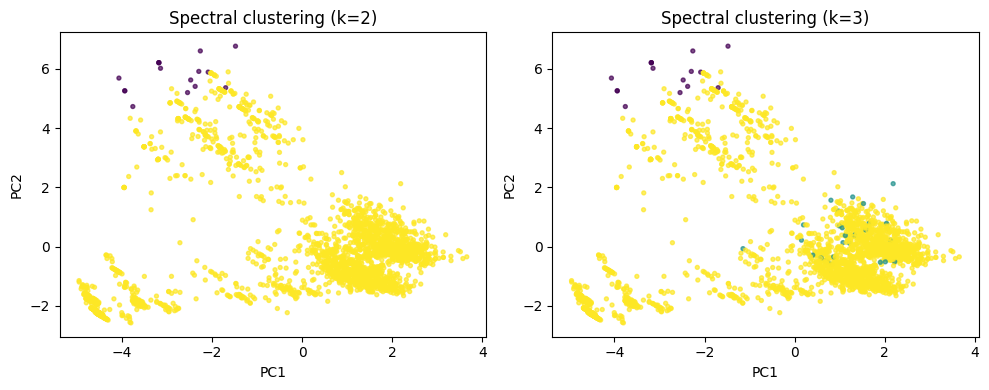

In [32]:
# ==========================
# Gráficas 2D de los clusters
# ==========================
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# k = 2
sc0 = axes[0].scatter(
    X_spec_2d[:, 0],
    X_spec_2d[:, 1],
    c=labels_k2,
    s=8,
    alpha=0.7
)
axes[0].set_title("Spectral clustering (k=2)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# k = 3
sc1 = axes[1].scatter(
    X_spec_2d[:, 0],
    X_spec_2d[:, 1],
    c=labels_k3,
    s=8,
    alpha=0.7
)
axes[1].set_title("Spectral clustering (k=3)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


El Spectral Clustering sobre el embedding de ACP identifica, de manera consistente, dos grupos de alta severidad:

Pacientes críticos pediátricos en UCI pediátrica, predominantemente con condiciones maternas perinatales y edad media inferior a 1 año.

Pacientes críticos adultos en UCI adultos, con edad media cercana a los 65 años y predominio de enfermedades no transmisibles, pero con proporciones relevantes de causas transmisibles y diagnósticos inespecíficos.

El resto de los pacientes se agrupa en un gran cluster asociado a hospitalización convencional (adultos, ginecobstetricia y pediatría no UCI), dominado por enfermedades no transmisibles.

Con k=2, el modelo distingue únicamente el cluster pediátrico crítico frente al resto.

Con k=3, se obtiene una estructura más rica, separando además a los adultos críticos como grupo propio, lo cual tiene sentido desde la perspectiva de gestión clínica y uso de recursos (UCI versus no UCI).

CLUSTERING JERARQUICO

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# ============================
# 1) Submuestra
# ============================
rng = np.random.RandomState(0)

n_muestras_hier = min(3000, X_pca.shape[0])  # ajusta si quieres menos/más
idx_hier = rng.choice(X_pca.shape[0], size=n_muestras_hier, replace=False)

X_hier = X_pca[idx_hier]          # para clusterizar (todas las comps del ACP)
X_hier_2d = X_hier[:, :2]         # solo PC1 y PC2 para graficar
df_hier = df.iloc[idx_hier].copy()

print("Shape X_hier:", X_hier.shape)

# ============================
# 2) Matriz de conectividad (grafo k-NN)
# ============================
connectivity = kneighbors_graph(
    X_hier,
    n_neighbors=15,       # puedes probar 10–20
    include_self=False,
    n_jobs=-1
)


Shape X_hier: (3000, 60)


In [34]:
def agglomerative_y_metricas(X, n_clusters, linkage="ward", connectivity=None, rng=None):
    """
    Ejecuta AgglomerativeClustering y calcula Silhouette, CH y DB.
    X: matriz de características (ACP).
    linkage: 'ward', 'average', 'complete', 'single'.
    """
    if rng is None:
        rng = np.random.RandomState(0)

    # Para 'ward' NO pasamos metric (se asume euclidean)
    if linkage == "ward":
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage="ward",
            connectivity=connectivity
        )
    else:
        # Para otros linkages, sí especificamos la métrica
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage,
            metric="euclidean",   # puedes cambiarla si quieres
            connectivity=connectivity
        )

    labels = model.fit_predict(X)

    # Silhouette en submuestra para no morir en tiempo
    n_muestras_sil = min(1000, X.shape[0])
    idx_sil = rng.choice(X.shape[0], size=n_muestras_sil, replace=False)

    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        sil = np.nan
        ch = np.nan
        db = np.nan
    else:
        sil = silhouette_score(X[idx_sil], labels[idx_sil])
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)

    metricas = {
        "k": n_clusters,
        "linkage": linkage,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
        "n_labels_real": len(unique_labels),
    }
    return labels, metricas


In [35]:
lista_k = range(2, 7)   # k = 2,...,6
linkages = ["ward"]     # puedes añadir "average", "complete" si quieres

resultados = []
labels_guardados = {}   # para guardar algunas particiones

for link in linkages:
    for k in lista_k:
        print(f"\n=== Agglomerative (linkage={link}, k={k}) ===")
        labels, mets = agglomerative_y_metricas(
            X_hier,
            n_clusters=k,
            linkage=link,
            connectivity=connectivity,
            rng=rng
        )
        print(mets)
        resultados.append(mets)

        # Guarda algunos resultados para graficar luego (por ejemplo k=2 y k=3)
        if (link == "ward") and (k in [2, 3]):
            labels_guardados[(link, k)] = labels

# Tabla resumen de métricas
resultados_hier_df = pd.DataFrame(resultados).sort_values(
    by=["silhouette", "calinski_harabasz", "davies_bouldin"],
    ascending=[False, False, True]
)

resultados_hier_df



=== Agglomerative (linkage=ward, k=2) ===


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


{'k': 2, 'linkage': 'ward', 'silhouette': np.float64(0.0485519538938521), 'calinski_harabasz': np.float64(142.61817471613028), 'davies_bouldin': np.float64(3.0739429547210615), 'n_labels_real': 2}

=== Agglomerative (linkage=ward, k=3) ===


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


{'k': 3, 'linkage': 'ward', 'silhouette': np.float64(-0.008120915755279172), 'calinski_harabasz': np.float64(128.74601918343419), 'davies_bouldin': np.float64(2.342894447098447), 'n_labels_real': 3}

=== Agglomerative (linkage=ward, k=4) ===


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


{'k': 4, 'linkage': 'ward', 'silhouette': np.float64(0.01725420195246334), 'calinski_harabasz': np.float64(123.03510659054318), 'davies_bouldin': np.float64(1.8041899160561832), 'n_labels_real': 4}

=== Agglomerative (linkage=ward, k=5) ===


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


{'k': 5, 'linkage': 'ward', 'silhouette': np.float64(0.01241358618229987), 'calinski_harabasz': np.float64(121.66048725649057), 'davies_bouldin': np.float64(1.5078681134482192), 'n_labels_real': 5}

=== Agglomerative (linkage=ward, k=6) ===


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


{'k': 6, 'linkage': 'ward', 'silhouette': np.float64(0.0033458418393141655), 'calinski_harabasz': np.float64(119.05960883749886), 'davies_bouldin': np.float64(1.2911307474934575), 'n_labels_real': 6}


,k,linkage,silhouette,calinski_harabasz,davies_bouldin,n_labels_real
0,2,ward,0.048552,142.618175,3.073943,2
2,4,ward,0.017254,123.035107,1.804190,4
3,5,ward,0.012414,121.660487,1.507868,5
4,6,ward,0.003346,119.059609,1.291131,6
1,3,ward,-0.008121,128.746019,2.342894,3


El clustering jerárquico aglomerativo con enlace de Ward sobre el embedding del ACP no revela una estructura de clusters tan marcada como la observada con Spectral Clustering. Los valores del índice de silueta son cercanos a cero para todos los números de clusters probados (k=2–6), lo que indica un solapamiento importante entre grupos y una separación global débil en este espacio.
Las variaciones en los índices de Calinski–Harabasz y Davies–Bouldin son modestas y no señalan un valor de k claramente óptimo. En este sentido, el modelo jerárquico se utiliza más como herramienta complementaria y exploratoria, mientras que la segmentación principal se apoya en los modelos que muestran una estructura de clusters más definida (K-means y Spectral).

DBSCAN

In [36]:
import numpy as np
import pandas as pd

# X_pca: salida de tu PCA con todas las observaciones
# n_componentes que usaremos para DBSCAN
n_comp_dbscan = 10

X_db = X_pca[:, :n_comp_dbscan]  # (n_muestras, 10)
X_db.shape


(141155, 10)

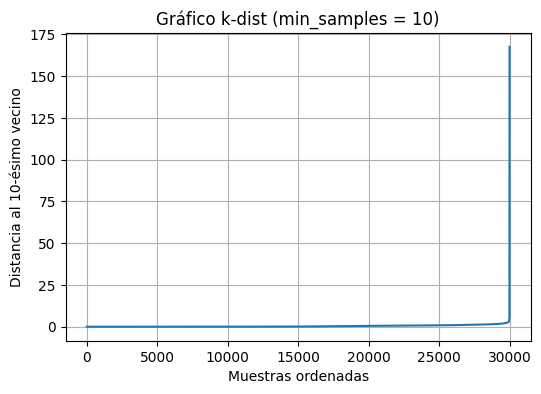

In [37]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# --- Muestra para el k-distance plot ---
n_muestras_kdist = min(30000, X_db.shape[0])
idx_kdist = np.random.choice(X_db.shape[0], size=n_muestras_kdist, replace=False)
X_db_sample = X_db[idx_kdist]

# --- Parámetro min_samples que quieres explorar ---
min_samples = 10  # puedes probar 5, 10, 20, etc.

nbrs = NearestNeighbors(n_neighbors=min_samples, metric="euclidean")
nbrs.fit(X_db_sample)
distances, indices = nbrs.kneighbors(X_db_sample)

# Distancia al k-ésimo vecino (última columna)
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.ylabel(f"Distancia al {min_samples}-ésimo vecino")
plt.xlabel("Muestras ordenadas")
plt.title(f"Gráfico k-dist (min_samples = {min_samples})")
plt.grid(True)
plt.show()


In [38]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# =========================
# 1) Muestras para acelerar
# =========================

# Muestra para DBSCAN en el barrido de eps
n_muestras_db = min(20000, X_db.shape[0])      # puedes bajar a 10k si sigue pesado
idx_db = np.random.choice(X_db.shape[0], size=n_muestras_db, replace=False)
X_db_sample = X_db[idx_db]

# Dentro de cada modelo tomamos otra submuestra para la silueta
n_muestras_sil = 5000   # máximo de puntos para silhouette

eps_values = np.linspace(0.3, 3.0, 10)  # menos valores también ayuda
resultados = []

for eps in eps_values:
    print(f"Probando eps = {eps:.3f} ...")

    dbscan = DBSCAN(
        eps=eps,
        min_samples=min_samples,
        metric="euclidean",
        n_jobs=-1
    )

    labels_sample = dbscan.fit_predict(X_db_sample)

    # Clusters distintos de -1 (ruido)
    mask_validos = labels_sample != -1
    etiquetas_validas = labels_sample[mask_validos]
    n_clusters = len(np.unique(etiquetas_validas))
    prop_ruido = np.mean(labels_sample == -1)

    # ==========================
    # Silhouette SOLO si tiene sentido
    # ==========================
    if n_clusters > 1 and etiquetas_validas.size > 0:
        # Submuestra para la silueta
        X_validos = X_db_sample[mask_validos]
        n_s = min(n_muestras_sil, X_validos.shape[0])
        idx_sil = np.random.choice(X_validos.shape[0], size=n_s, replace=False)

        sil = silhouette_score(X_validos[idx_sil], etiquetas_validas[idx_sil])
    else:
        sil = np.nan

    resultados.append({
        "eps": eps,
        "n_clusters": n_clusters,
        "prop_ruido": prop_ruido,
        "silhouette": sil
    })

resultados_dbscan = pd.DataFrame(resultados)
resultados_dbscan


Probando eps = 0.300 ...
Probando eps = 0.600 ...
Probando eps = 0.900 ...
Probando eps = 1.200 ...
Probando eps = 1.500 ...
Probando eps = 1.800 ...
Probando eps = 2.100 ...
Probando eps = 2.400 ...
Probando eps = 2.700 ...
Probando eps = 3.000 ...


,eps,n_clusters,prop_ruido,silhouette
0,0.3,245,0.43315,0.684127
1,0.6,219,0.30525,0.524786
2,0.9,133,0.13435,0.128685
3,1.2,45,0.07375,-0.121938
4,1.5,32,0.03160,-0.050862
5,1.8,19,0.01525,0.024787
6,2.1,9,0.00715,0.325681
7,2.4,5,0.00395,0.349470
8,2.7,6,0.00115,0.352859
9,3.0,6,0.00045,0.353560


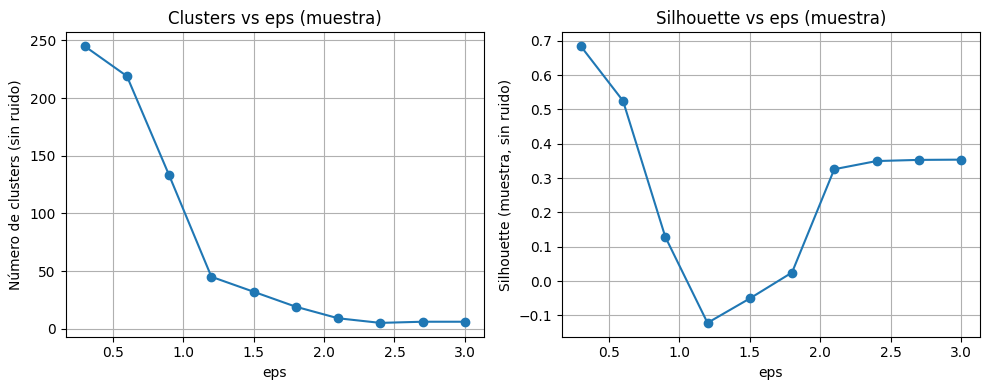

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(resultados_dbscan["eps"], resultados_dbscan["n_clusters"], marker="o")
ax[0].set_xlabel("eps")
ax[0].set_ylabel("Número de clusters (sin ruido)")
ax[0].set_title("Clusters vs eps (muestra)")
ax[0].grid(True)

ax[1].plot(resultados_dbscan["eps"], resultados_dbscan["silhouette"], marker="o")
ax[1].set_xlabel("eps")
ax[1].set_ylabel("Silhouette (muestra, sin ruido)")
ax[1].set_title("Silhouette vs eps (muestra)")
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [40]:
eps_opt = resultados_dbscan.sort_values("silhouette", ascending=False)["eps"].iloc[0]
eps_opt


np.float64(0.3)

In [41]:
db_final = DBSCAN(
    eps=eps_opt,
    min_samples=min_samples,
    metric="euclidean",
    n_jobs=-1
)

labels_db = db_final.fit_predict(X_db)

df_db = df.copy()
df_db["cluster_DBSCAN"] = labels_db
df_db["es_ruido"] = (labels_db == -1).astype(int)

df_db["cluster_DBSCAN"].value_counts().sort_index()


,count
cluster_DBSCAN,
-1,30299
0,59
1,94
2,162
3,78
...,...
1445,10
1446,10
1447,10


In [42]:
from sklearn.metrics import silhouette_score

mask_validos = labels_db != -1
X_validos_full = X_db[mask_validos]
y_validos_full = labels_db[mask_validos]

n_s_final = min(10000, X_validos_full.shape[0])  # por si acaso
idx_s_final = np.random.choice(X_validos_full.shape[0], size=n_s_final, replace=False)

sil_final = silhouette_score(X_validos_full[idx_s_final], y_validos_full[idx_s_final])
sil_final


np.float64(0.6068799545879421)

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

eps_opt = 2.7          # según el barrido que hiciste
min_samples_opt = min_samples   # usa el mismo que definiste antes (p.ej. 10)

db_final = DBSCAN(
    eps=eps_opt,
    min_samples=min_samples_opt,
    metric="euclidean",
    n_jobs=-1
)

labels_db = db_final.fit_predict(X_db)  # X_db = componentes de ACP

# Unimos con tu dataframe original
df_db = df.copy()
df_db["cluster_DBSCAN"] = labels_db
df_db["es_ruido"] = (labels_db == -1).astype(int)

# Tamaño de cada cluster (incluyendo ruido -1)
conteo_clusters = (
    df_db["cluster_DBSCAN"]
    .value_counts()
    .sort_index()
    .rename_axis("cluster_DBSCAN")
    .reset_index(name="n_pacientes")
)

conteo_clusters
